## Penjelasan Dataset yang digunakan

### 1. Kasus yang diambil:

Kasus ini adalah Topic Modeling (Pemodelan Topik) dari judul berita bahasa Indonesia. Tujuannya adalah untuk menemukan topik-topik tersembunyi (kluster kata) yang ada di dalam ribuan judul berita secara otomatis (tanpa pengawasan/unsupervised).

Kita akan menggunakan kolom tittle (judul) sebagai data teks utama. Kolom category dapat digunakan sebagai pembanding atau label untuk memvalidasi hasil visualisasi kita nanti (misalnya, apakah topik yang ditemukan sesuai dengan kategori yang ada).

### 2. Penjelasan tiap kolom

Dataset indonesian-news-title.csv memiliki kolom:
- date: Tanggal publikasi berita.
- url: Tautan (URL) ke sumber berita.
- tittle: Judul berita (ini akan menjadi teks utama yang kita analisis).
- category: Kategori berita yang diberikan oleh sumber.

### 3. Import Library

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # Regular Expressions untuk membersihkan teks
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Sastrawi untuk stemming dan stopword Bahasa Indonesia
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

# Sklearn untuk pemrosesan, modeling, dan visualisasi
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

# Visualisasi
from wordcloud import WordCloud

# Mengatur tampilan plot
%matplotlib inline
sns.set(style="whitegrid")

# Download resource NLTK (hanya perlu sekali)
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### 4. Load Data


In [87]:
# Tentukan path ke file Anda
file_path = './dataset/indonesian-news-title.csv'

# Muat dataset
try:
    df = pd.read_csv(file_path)
    # Ganti nama 'tittle' menjadi 'title' agar lebih standar
    if 'tittle' in df.columns:
        df.rename(columns={'tittle': 'title'}, inplace=True)
    
    print("Data berhasil dimuat.")
    print(df.head())
except FileNotFoundError:
    print(f"Error: File '{file_path}' tidak ditemukan.")
    print("Pastikan file tersebut berada di direktori yang sama dengan notebook Anda, atau ubah 'file_path'.")

Data berhasil dimuat.
         date                                                url  \
0  02/26/2020  https://finance.detik.com/berita-ekonomi-bisni...   
1  02/26/2020  https://finance.detik.com/berita-ekonomi-bisni...   
2  02/26/2020  https://finance.detik.com/berita-ekonomi-bisni...   
3  02/26/2020  https://finance.detik.com/moneter/d-4916133/oj...   
4  02/26/2020  https://finance.detik.com/berita-ekonomi-bisni...   

                                               title category  
0                     Kemnaker Awasi TKA di Meikarta  finance  
1                  BNI Digitalkan BNI Java Jazz 2020  finance  
2  Terbang ke Australia, Edhy Prabowo Mau Genjot ...  finance  
3  OJK Siapkan Stimulus Ekonomi Antisipasi Dampak...  finance  
4  Saran Buat Anies-RK yang Mangkir Rapat Banjir ...  finance  


## Data Understanding

### 1. Jumlah baris data

In [88]:
print(f"Jumlah total baris (judul berita): {len(df)}")
# Cara lain:
print(f"Bentuk data (baris, kolom): {df.shape}")

Jumlah total baris (judul berita): 91017
Bentuk data (baris, kolom): (91017, 4)


### 2. Panjang rata-rata setiap baris

In [89]:
# Pastikan kolom 'title' ada dan bertipe string
if 'title' in df.columns:
    df['title_length'] = df['title'].astype(str).apply(len)
    print(f"Panjang rata-rata judul berita: {df['title_length'].mean():.2f} karakter")
    
    # Tampilkan 5 judul terpendek dan terpanjang
    print("\n5 Judul Terpendek:")
    print(df.sort_values(by='title_length').head()[['title', 'title_length']])
    print("\n5 Judul Terpanjang:")
    print(df.sort_values(by='title_length', ascending=False).head()[['title', 'title_length']])
else:
    print("Error: Kolom 'title' tidak ditemukan.")

Panjang rata-rata judul berita: 60.36 karakter

5 Judul Terpendek:
       title  title_length
42734   Love             4
36055  Tulah             5
30171  Karma             5
31761  Alien             5
46534  Diam!             5

5 Judul Terpanjang:
                                                   title  title_length
15526  Kuliner New Normal Terapkan 'Social Distancing...           107
18400  Galeri Foto Saling Sindir dengan Lucinta Luna,...           105
17422  Makan Malam Romantis 5 Alasan Cokelat Identik ...           105
14507  Berita Terpopuler Dua Coffee Jadi Sasaran Demo...           103
17226  Ardi Bakrie hingga Michael Bambang Hartono, 5 ...           103


### 3. Cek data duplikasi

In [90]:
if 'title' in df.columns:
    duplicated_titles = df.duplicated(subset=['title']).sum()
    print(f"Jumlah judul berita yang duplikat: {duplicated_titles}")
    
    # Opsional: Tampilkan beberapa data duplikat
    if duplicated_titles > 0:
        print("\nContoh data duplikat:")
        print(df[df.duplicated(subset=['title'], keep=False)].sort_values(by='title').head())
        
    # Opsional: Hapus data duplikat jika diinginkan
    # df_unique = df.drop_duplicates(subset=['title'])
    # print(f"Jumlah data setelah duplikat dihapus: {len(df_unique)}")
else:
    print("Error: Kolom 'title' tidak ditemukan.")

Jumlah judul berita yang duplikat: 126

Contoh data duplikat:
             date                                                url  \
36982  04/24/2020  https://hot.detik.com/tv-news/d-4989920/the-ex...   
36985  04/24/2020  https://hot.detik.com/tv-news/d-4989895/the-ex...   
55232  03/06/2020  https://news.detik.com/berita/d-4927819/1-wni-...   
18763  03/06/2020  https://health.detik.com/berita-detikhealth/d-...   
70942  03/04/2020  https://news.detik.com/berita/d-4925818/11-ora...   

                                                   title category  \
36982  'The Expendables 3' dan 'A Good Man' Tayang di...      hot   
36985  'The Expendables 3' dan 'A Good Man' Tayang di...      hot   
55232  1 WNI ABK Diamond Princess Dicurigai COVID-19,...     news   
18763  1 WNI ABK Diamond Princess Dicurigai COVID-19,...   health   
70942  11 Orang Kontak Langsung dengan WN Jepang di B...     news   

       title_length  
36982            63  
36985            63  
55232            75  
18

### 4. Cek data kosong

In [91]:
print("Cek data kosong (NaN/Null) per kolom:")
print(df.isnull().sum())

Cek data kosong (NaN/Null) per kolom:
date            0
url             0
title           0
category        0
title_length    0
dtype: int64


### 5. Distribusi data

- Distribusi Kategori (Bar Chart)

C:\Users\user\AppData\Local\Temp\ipykernel_12776\1753590237.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='category', data=df, order=df['category'].value_counts().index, palette='viridis')


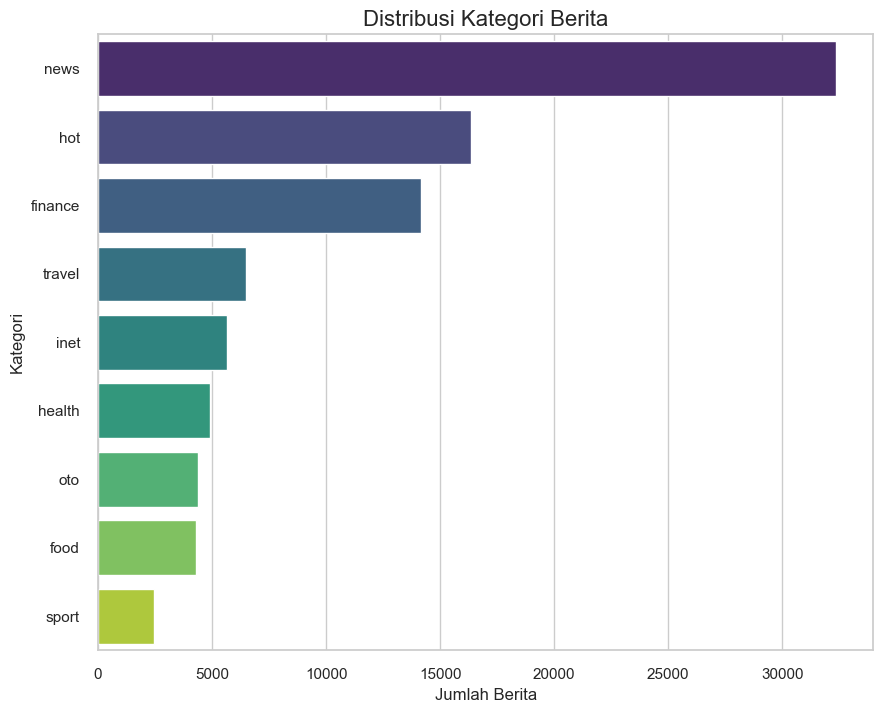

In [92]:
plt.figure(figsize=(10, 8))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index, palette='viridis')
plt.title('Distribusi Kategori Berita', fontsize=16)
plt.xlabel('Jumlah Berita', fontsize=12)
plt.ylabel('Kategori', fontsize=12)
plt.show()

- Kata yang Sering Muncul (Word Cloud)

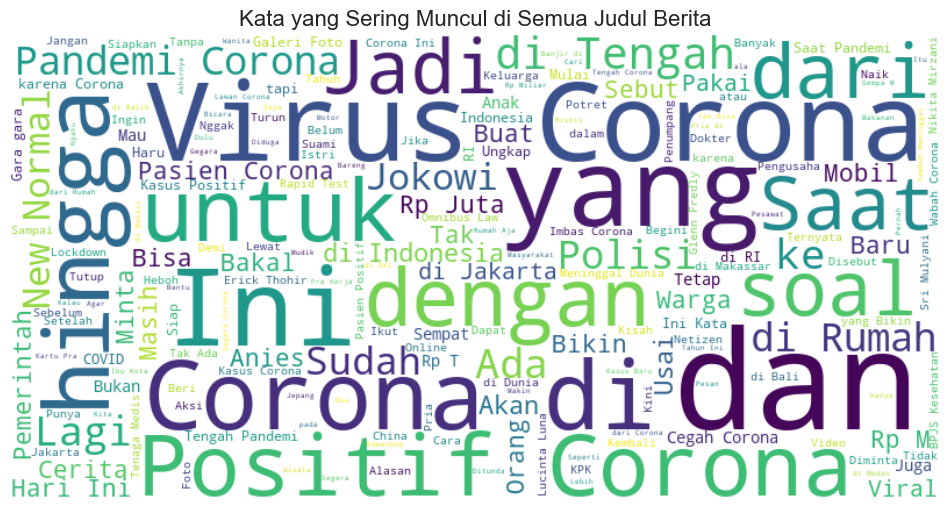

In [93]:
if 'title' in df.columns:
    # Gabungkan semua judul menjadi satu teks besar
    all_titles = ' '.join(df['title'].astype(str).tolist())
    
    # Buat Word Cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_titles)
    
    # Tampilkan
    plt.figure(figsize=(12, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Kata yang Sering Muncul di Semua Judul Berita', fontsize=16)
    plt.show()
else:
    print("Error: Kolom 'title' tidak ditemukan.")

## Data Text Processing

### 1. Tokenisasi

In [ ]:
# Tokenisasi
def tokenize_text(text):
    return word_tokenize(text)

### 2. Lemmatization

In [ ]:
# Lemmatization (Menggunakan stemmer Sastrawi)
def lemmatize_text(tokens):
    # Di Sastrawi, stemming adalah proses mencari kata dasar (lemma)
    print("Menggunakan Stemmer Sastrawi sebagai Lemmatizer...")
    # Kita butuh 'stemmer' dari langkah 3, pastikan langkah 3 sudah dijalankan
    return [stemmer.stem(token) for token in tokens]

### 3. Stemming

In [ ]:
# --- Setup Stemmer ---
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

# --- Definisi Fungsi Stemming ---
# Stemming
def stem_text(tokens):
    # Stemming bekerja per kata (token)
    return [stemmer.stem(token) for token in tokens]

### 4. Stopword Removal

In [ ]:
# --- Setup Stopword ---
stopword_factory = StopWordRemoverFactory()
# Tambahkan stopwords kustom jika perlu
more_stopwords = ['yg', 'dg', 'rt', 'dgn', 'ny', 'd', 'k', 'ke', 'di', 'dari', 'ter', 'juta', 'rp']
data_stopwords = stopword_factory.get_stop_words() + more_stopwords
# Buat dictionary untuk Sastrawi
dictionary = ArrayDictionary(data_stopwords)
stopword_remover = StopWordRemover(dictionary)

# --- Definisi Fungsi Stopword Removal ---
# Stopword removal
def remove_stopwords_internal(tokens):
    # Sastrawi stopword remover bekerja pada string, bukan token
    # Jadi kita gabung dulu lalu proses
    text = ' '.join(tokens)
    text_no_stop = stopword_remover.remove(text)
    # Tokenisasi ulang setelah stopwords dihapus
    return word_tokenize(text_no_stop)

### 5. Text Normalisasi

In [ ]:
# Text Normalisasi (termasuk case folding, hapus angka & tanda baca)
def normalize_text(text):
    text = text.lower() # Case folding
    text = re.sub(r'\d+', '', text) # Hapus angka
    text = re.sub(r'[^\w\s]', '', text) # Hapus tanda baca
    text = text.strip() # Hapus spasi berlebih
    return text

- Run code

In [113]:
# --- Terapkan Pipeline ---
print("Memulai Text Processing...")
if 'title' in df.columns:
    # Ambil sampel data jika dataset terlalu besar (misal 5000 baris)
    # df_sample = df.sample(5000, random_state=42).copy()
    # Jika ingin proses semua data, gunakan baris di bawah:
    df_sample = df.sample(500, random_state=42).copy()
    
    print(f"Memproses {len(df_sample)} baris data... (Ini mungkin lambat)")

    # Terapkan pipeline
    # (Biasanya kita pilih Stemming ATAU Lemmatization, di sini kita gunakan Stemming)
    
    # Langkah 5: Normalisasi
    df_sample['clean_title'] = df_sample['title'].astype(str).apply(normalize_text)
    # Langkah 1: Tokenisasi
    df_sample['tokens'] = df_sample['clean_title'].apply(tokenize_text)
    # Langkah 4: Stopword Removal
    df_sample['tokens_no_stop'] = df_sample['tokens'].apply(remove_stopwords_internal)
    
    # Langkah 3: Stemming
    # PERINGATAN: Stemming sangat lambat!
    print("Memulai proses Stemming (Paling lama)...")
    df_sample['tokens_stemmed'] = df_sample['tokens_no_stop'].apply(stem_text)
    
    # Gabungkan kembali token yang sudah bersih menjadi kalimat
    df_sample['final_text'] = df_sample['tokens_stemmed'].apply(lambda x: ' '.join(x))
    
    print("Text Processing Selesai.")
    print(df_sample[['title', 'final_text']].head())
else:
    print("Error: Kolom 'title' tidak ditemukan untuk diproses.")

Memulai Text Processing...
Memproses 500 baris data... (Ini mungkin lambat)
Memulai proses Stemming (Paling lama)...
Text Processing Selesai.
                                                   title  \
54603  Pasien Eka Hospital Bogor yang Negatif Corona ...   
75780  Video Warga Natuna Ramai-ramai Demo Tolak Jadi...   
49569  Update Corona di RI 5 Juni: Kasus Positif 29.5...   
47869  Kepsek Harap RK-Walkot Bekasi Relokasi Gedung ...   
3094   Penasaran Sama Masker Jokowi? Ternyata Belinya...   

                                              final_text  
54603     pasien eka hospital bogor negatif corona rawat  
75780  video warga natuna ramairamai demo tolak jadi ...  
49569  update corona ri juni kasus positif sembuh tin...  
47869  kepsek harap rkwalkot bekas relokasi gedung sd...  
3094        penasaran sama masker jokowi nyata beli sini  


### 6. Text Vektorisasi

In [114]:
# Inisialisasi TF-IDF Vectorizer
# max_df = 0.95 -> abaikan kata yang muncul di > 95% dokumen
# min_df = 2 -> abaikan kata yang muncul di < 2 dokumen
# max_features = 1000 -> ambil 1000 kata terpenting
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000)

# Terapkan vectorizer ke teks bersih kita
tfidf_matrix = vectorizer.fit_transform(df_sample['final_text'])

# Dapatkan nama-nama fitur (kata-kata)
feature_names = vectorizer.get_feature_names_out()

print(f"Bentuk matriks TF-IDF: {tfidf_matrix.shape}")
print(f"Contoh 10 fitur (kata): {feature_names[:10]}")

Bentuk matriks TF-IDF: (500, 634)
Contoh 10 fitur (kata): ['abk' 'acara' 'aceh' 'ada' 'ahok' 'air' 'akhir' 'akibat' 'aksi' 'aktor']


## Data Modeling

#### Penjelasan tentang model yang dipilih

Kita akan menggunakan Latent Dirichlet Allocation (LDA).

LDA adalah model generatif probabilistik yang digunakan untuk topic modeling. Asumsi dasarnya adalah:

1. Setiap dokumen (judul berita) adalah campuran dari berbagai topik.
2. Setiap topik adalah campuran dari berbagai kata.

LDA akan melihat matriks TF-IDF (atau CountVectorizer) dan mencoba mencari tahu:

- Topik apa saja yang ada di seluruh dataset? (Misal: Topik A: 'polisi', 'tangkap', 'korupsi'; Topik B: 'saham', 'ihsg', 'rupiah')
- Seberapa besar proporsi setiap topik dalam setiap dokumen? (Misal: Judul "Polisi Tangkap Koruptor" adalah 90% Topik A dan 10% Topik B).

Kita perlu menentukan jumlah topik (n_components) yang ingin kita cari.

In [115]:
# Tentukan jumlah topik yang ingin dicari (misalnya 5 atau 10)
# Ini adalah hyperparameter yang bisa disesuaikan
NUM_TOPICS = 10 

# Buat model LDA
# Catatan: LDA secara teknis lebih baik bekerja dengan CountVectorizer,
# tetapi TF-IDF juga bisa digunakan.
lda = LatentDirichletAllocation(
    n_components=NUM_TOPICS, 
    max_iter=10, 
    learning_method='online', 
    random_state=42
)

# Latih model LDA pada matriks TF-IDF
print("Melatih model LDA...")
lda.fit(tfidf_matrix)
print("Pelatihan LDA selesai.")

Melatih model LDA...
Pelatihan LDA selesai.


## Visualisasi Topic yang dimunculkan menggunakan tabel, barchart dan sebagainya

### 1. Tabel Topik

In [116]:
def display_topics(model, feature_names, num_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topic_dict[f"Topik {topic_idx+1}"] = top_words
    return pd.DataFrame(topic_dict)

num_top_words = 10
topics_df = display_topics(lda, feature_names, num_top_words)

print(f"Kata-kata Teratas untuk Setiap Topik (Top {num_top_words} Words):")
display(topics_df)

Kata-kata Teratas untuk Setiap Topik (Top 10 Words):


,Topik 1,Topik 2,Topik 3,Topik 4,Topik 5,Topik 6,Topik 7,Topik 8,Topik 9,Topik 10
0,virus,new,corona,tahun,tinggal,jadi,baru,pecah,siap,kerja
1,corona,pakai,pasien,soal,bakal,corona,polisi,tolak,banjir,cerita
2,indonesia,normal,minta,temu,jaga,warga,rumah,lihat,catat,bukan
3,besar,harga,tinggal,rilis,mulai,orang,tenaga,bebas,jakarta,tak
4,mati,baju,perintah,kota,beda,apa,bekas,solo,hadap,as
5,asyik,juli,positif,ri,pasar,hari,sakit,buat,jokowi,dunia
6,awas,beli,rawat,bikin,traveling,video,temu,wajib,ikan,corona
7,jangan,tahu,negatif,tewas,laku,diri,maaf,kue,musim,mudik
8,sebut,lebih,warga,instagram,duka,polisi,lagu,cegah,tanah,acara
9,hingga,babak,the,corona,rsud,kasus,corona,hasil,bagi,galeri


### 2. Bar Chart untuk Topik

C:\Users\user\AppData\Local\Temp\ipykernel_12776\4072660408.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words_values, y=top_words, palette='coolwarm')


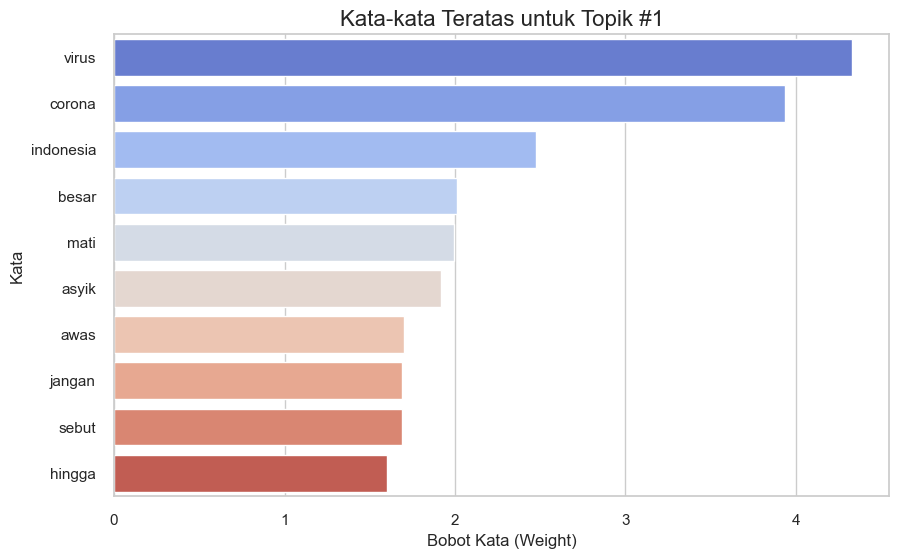

C:\Users\user\AppData\Local\Temp\ipykernel_12776\4072660408.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words_values, y=top_words, palette='coolwarm')


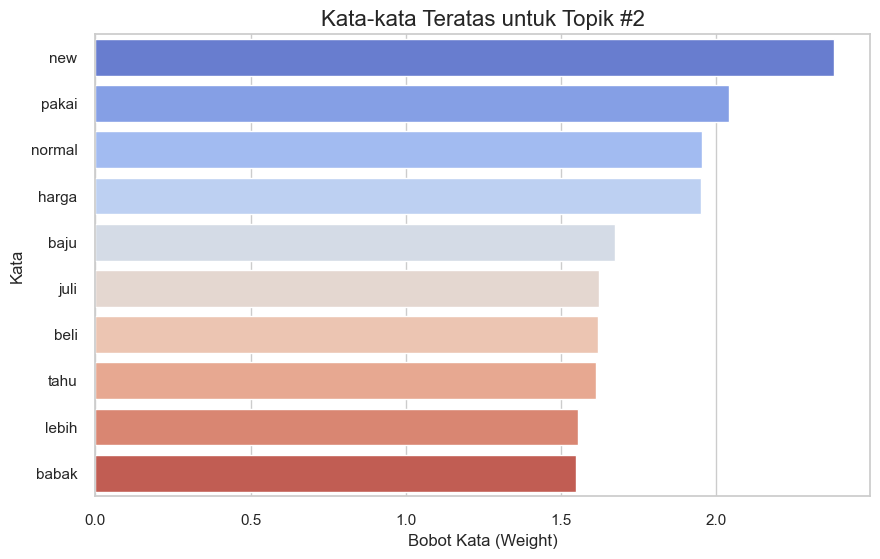

C:\Users\user\AppData\Local\Temp\ipykernel_12776\4072660408.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_words_values, y=top_words, palette='coolwarm')


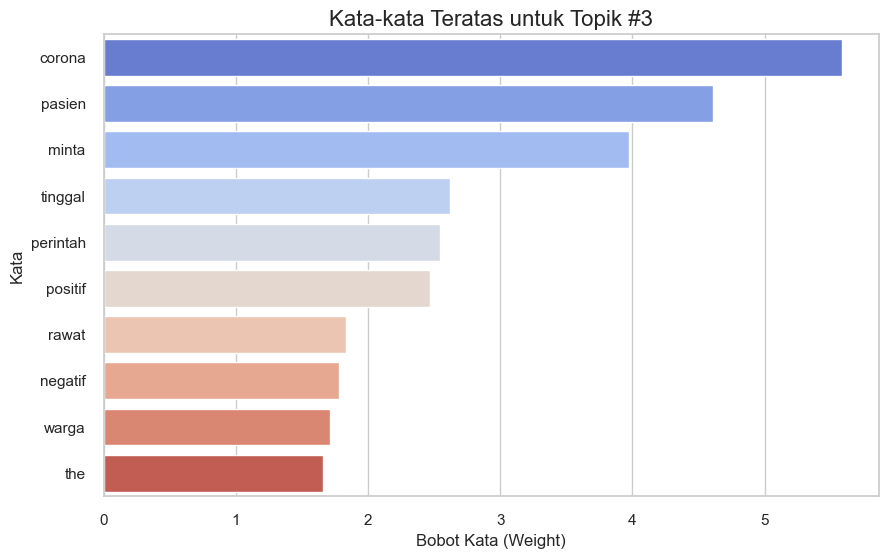

In [119]:
def plot_top_words(model, feature_names, topic_idx, n_top_words):
    topic = model.components_[topic_idx]
    top_words_indices = topic.argsort()[:-n_top_words - 1:-1]
    top_words = [feature_names[i] for i in top_words_indices]
    top_words_values = [topic[i] for i in top_words_indices]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_words_values, y=top_words, palette='coolwarm')
    plt.title(f'Kata-kata Teratas untuk Topik #{topic_idx+1}', fontsize=16)
    plt.xlabel('Bobot Kata (Weight)', fontsize=12)
    plt.ylabel('Kata', fontsize=12)
    plt.show()

# Visualisasikan 3 topik pertama
plot_top_words(lda, feature_names, 0, 10) # Topik 1
plot_top_words(lda, feature_names, 1, 10) # Topik 2
plot_top_words(lda, feature_names, 2, 10) # Topik 3

### 3. Word Cloud untuk Topik


Menampilkan Word Cloud untuk 6 Topik Teratas...


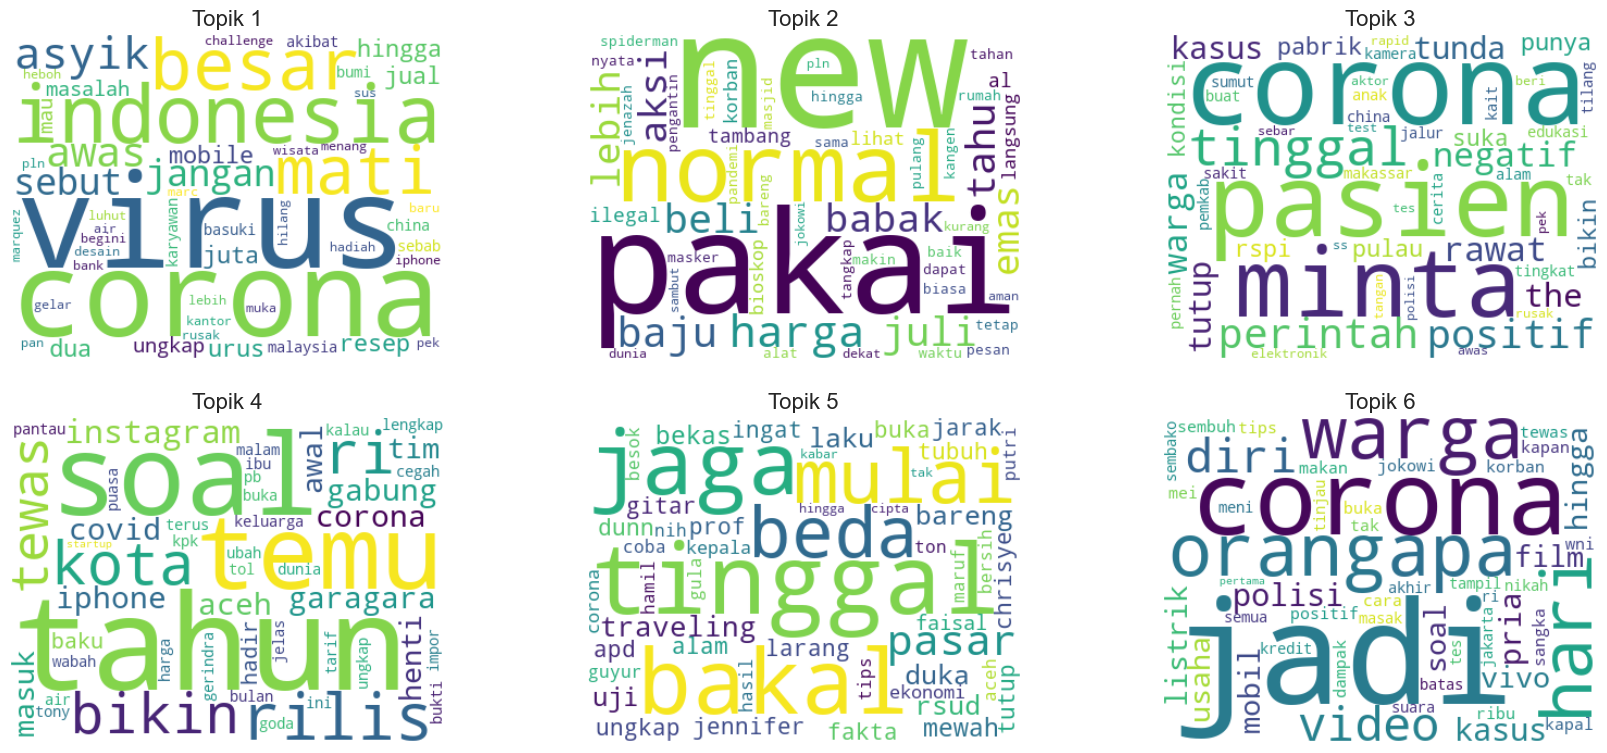

In [120]:
# Fungsi untuk membuat dictionary frekuensi/bobot kata untuk satu topik
def get_topic_word_weights(topic_component, feature_names):
    # Membuat dictionary: {kata: bobot}
    return {feature_names[i]: weight for i, weight in enumerate(topic_component)}

# Tentukan berapa banyak topik yang ingin divisualisasikan
# Ambil 6 topik pertama, atau semua jika total topik < 6
num_topics_to_plot = min(NUM_TOPICS, 6) 

# Tentukan layout grid (misal: 2 baris, 3 kolom)
ncols = 3
nrows = (num_topics_to_plot + ncols - 1) // ncols # Menghitung jumlah baris yg dibutuhkan

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 6, nrows * 4), squeeze=False)
axes = axes.flatten() # Ratakan array axes agar mudah di-loop

print(f"\nMenampilkan Word Cloud untuk {num_topics_to_plot} Topik Teratas...")

for i in range(num_topics_to_plot):
    ax = axes[i]
    
    # Dapatkan bobot kata untuk topik ke-i
    topic_weights = get_topic_word_weights(lda.components_[i], feature_names)
    
    # Buat WordCloud dari frekuensi (bobot)
    wc = WordCloud(
        width=400, 
        height=300, 
        background_color='white', 
        colormap='viridis',
        max_words=50 # Batasi jumlah kata agar tidak terlalu padat
    ).generate_from_frequencies(topic_weights)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'Topik {i+1}', fontsize=16)
    ax.axis('off')

# Sembunyikan subplot yang tidak terpakai (jika jumlah topik ganjil)
for i in range(num_topics_to_plot, len(axes)):
    axes[i].axis('off')

plt.tight_layout(pad=2.0)
plt.show()

## Gunakan implementasi menggunakan PCA atau T-sne untuk tahap lanjutan

Memulai proses t-SNE... (Ini mungkin lambat)
Peringatan: 'n_iter' tidak didukung oleh versi scikit-learn saat ini. Menggunakan nilai default iterasi.
Proses t-SNE selesai.


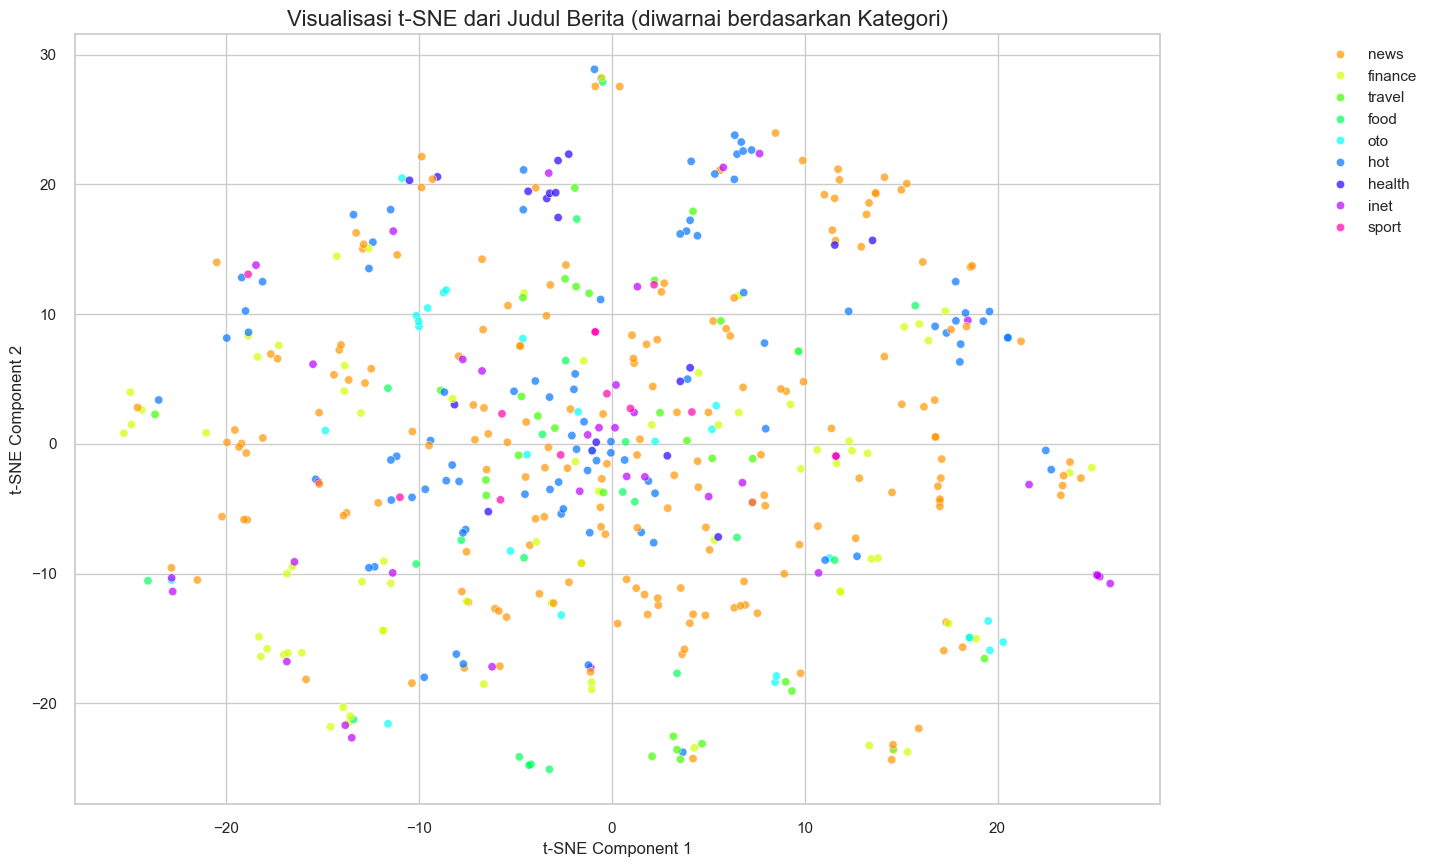

In [121]:
print("Memulai proses t-SNE... (Ini mungkin lambat)")

# --- Opsi 1: Langsung t-SNE (Mungkin lambat) ---
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
# tsne_results = tsne.fit_transform(tfidf_matrix.toarray()) # .toarray() butuh banyak memori

# --- Opsi 2: TruncatedSVD (PCA) dulu, baru t-SNE (Lebih cepat dan stabil) ---
# 1. Reduksi dimensi ke 50 dengan SVD (Sparse PCA)
svd = TruncatedSVD(n_components=50, random_state=42)
svd_matrix = svd.fit_transform(tfidf_matrix)

# 2. Terapkan t-SNE pada data 50 dimensi
try:
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
except TypeError:
    print("Peringatan: 'n_iter' tidak didukung oleh versi scikit-learn saat ini. Menggunakan nilai default iterasi.")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
tsne_results = tsne.fit_transform(svd_matrix)
tsne_results = tsne.fit_transform(svd_matrix)

print("Proses t-SNE selesai.")

# Buat DataFrame dari hasil t-SNE
df_tsne = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
# Tambahkan kolom kategori dari data asli
df_tsne['category'] = df_sample['category'].values

# Visualisasikan hasil t-SNE
plt.figure(figsize=(14, 10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="category",
    palette=sns.color_palette("hsv", len(df_tsne['category'].unique())),
    data=df_tsne,
    legend="full",
    alpha=0.7
)
plt.title('Visualisasi t-SNE dari Judul Berita (diwarnai berdasarkan Kategori)', fontsize=16)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
plt.show()